In [1]:
## importing packages ##
import numpy as np
import pandas as pd

import seaborn as sns

In [4]:
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import re

In [5]:
from bs4 import BeautifulSoup as bs
import requests

In [7]:
import string
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords,wordnet 
from wordcloud import WordCloud

In [9]:
from textblob import TextBlob

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

In [13]:
import pyLDAvis

In [14]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
def scrape_reviews(hotel_linkname,total_pages):
    '''
    Function to scrape hotel reviews from bookings.com
    INPUTS:
        hotel_linkname - hotel name in the bookings.com weblink
        total_pages - the total number of reviews pages to scrape
    OUTPUTS:
        reviewer_info - a dataframe that includes reviewers' basic information
        pos_reviews -  a dataframe that includes all the positive reviews 
        neg_reviews - a dataframe that includes all the negative reviews
    '''
    #Create empty lists to put in reviewers' information as well as all of the positive & negative reviews 
    info = []
    positive = []
    negative = []
    
    #bookings.com reviews link
    url = 'https://www.booking.com/reviews/us/hotel/'+ hotel_linkname +'.html?page=' 
    page_number = 1

    #Use a while loop to scrape all the pages 
    while page_number <= total_pages:

        page = requests.get(url + str(page_number)) #retrieve data from server
        soup = bs(page.text, "html.parser") # initiate a beautifulsoup object using the html source and Python’s html.parser
        review_box = soup.find('ul',{'class':'review_list'})

        #ratings
        ratings = [i.text.strip() for i in review_box.find_all('span',{'class':'review-score-badge'})]
        
        #reviewer_info
        reviewer_info = [i.text.strip() for i in review_box.find_all('span',{'itemprop':'name'})]
        reviewer_name = reviewer_info[0::3]
        reviewer_country = reviewer_info[1::3]
        general_review = reviewer_info[2::3]

        # reviewer_review_times
        review_times = [i.text.strip() for i in review_box.find_all('div',{'class':'review_item_user_review_count'})]

        # review_date
        review_date = [i.text.strip().strip('Reviewed: ') for i in review_box.find_all('p',{'class':'review_item_date'})]

        # reviewer_tag
        reviewer_tag = [i.text.strip().replace('\n\n\n','').replace('•',',').lstrip(', ') for i 
                        in review_box.find_all('ul',{'class':'review_item_info_tags'})]

        # positive_review
        positive_review = [i.text.strip('눇').strip() for i in review_box.find_all('p',{'class':'review_pos'})]

        # negative_review
        negative_review = [i.text.strip('눉').strip() for i in review_box.find_all('p',{'class':'review_neg'})]

        # append all reviewers' info into one list
        for i in range(len(reviewer_name)):
            info.append([ratings[i],reviewer_name[i],reviewer_country[i],general_review[i], 
                         review_times[i],review_date[i],reviewer_tag[i]])

        # build positive review list
        for i in range(len(positive_review)):
            positive.append(positive_review[i])

        # build negative review list
        for i in range(len(negative_review)):
            negative.append(negative_review[i])

        # page change
        page_number +=1

    #Reviewer_info df
    reviewer_info = pd.DataFrame(info,
                        columns = ['Rating','Name','Country','Overall_review','Review_times','Review_date','Review_tags'])
    reviewer_info['Rating'] = pd.to_numeric(reviewer_info['Rating'] )
    reviewer_info['Review_times'] = pd.to_numeric(reviewer_info['Review_times'].apply(lambda x:re.findall("\d+", x)[0]))
    reviewer_info['Review_date'] = pd.to_datetime(reviewer_info['Review_date'])
    
    #positive & negative reviews dfs
    pos_reviews = pd.DataFrame(positive,columns = ['positive_reviews'])
    neg_reviews = pd.DataFrame(negative,columns = ['negative_reviews'])
    
    return reviewer_info, pos_reviews, neg_reviews

def show_data(df):
    print("The length of the dataframe is: {}".format(len(df)))
    print("Total NAs: {}".format(reviewer_info.isnull().sum().sum()))
    return df.head()


In [17]:
reviewer_info, pos_reviews, neg_reviews = scrape_reviews('beresford',total_pages = 42)

In [19]:
#reviewers' basic information
show_data(reviewer_info) 

The length of the dataframe is: 1030
Total NAs: 0


Rating     Name                   Country  \
0     8.0     Ryan            United Kingdom   
1     7.0     Myth  United States of America   
2     6.0    Mandy               New Zealand   
3     6.0  Twyford            United Kingdom   
4     8.0     Eric  United States of America   

                                      Overall_review  Review_times  \
0                                          Very Good             2   
1                            Old but great location!             4   
2  Good value for money and great for one night’s...            22   
3  Old hotel with small rooms and old decor. incl...             7   
4                                          Very Good             1   

  Review_date                                        Review_tags  
0  2020-04-27  Leisure trip, Solo traveler, Queen Room, Staye...  
1  2020-04-07  Couple, Queen Room, Stayed 1 night, Submitted ...  
2  2020-03-24  Leisure trip, Couple, Queen Room, Stayed 2 nig...  
3  2020-03-21  Leisure trip, Group, Twin Room with Two Twin B...  
4  2020-03-21  Business trip, Solo traveler, Twin Room with T...

In [20]:
#positive reviews
show_data(pos_reviews) 

The length of the dataframe is: 651
Total NAs: 0


positive_reviews
0  Location is great, short walk away Chinatown a...
1  location more than made up for being outdated ...
2                                           Location
3  Location was good in the Union square area, go...
4                                           Location

In [21]:
# positive review
show_data(neg_reviews) 

The length of the dataframe is: 615
Total NAs: 0


negative_reviews
0  Relatively basic, however it is great value fo...
1  The hotel is very dated with yellow staining o...
2  Very old water pipes which made noises during ...
3  Breakfast was rubbish.... two types of flakes ...
4                 The toilet is too low to the floor

## Exploratory Data Analysis (EDA)

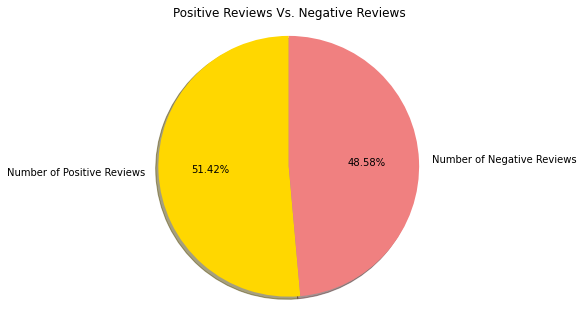

In [22]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
values = [len(pos_reviews), len(neg_reviews)]

ax.pie(values, 
       labels = ['Number of Positive Reviews', 'Number of Negative Reviews'],
       colors=['gold', 'lightcoral'],
       shadow=True,
       startangle=90, 
       autopct='%1.2f%%')
ax.axis('equal')
plt.title('Positive Reviews Vs. Negative Reviews');

In [23]:
# Histogram of Ratings
print(reviewer_info['Rating'].describe())
px.histogram(reviewer_info, x="Rating", nbins=30, title = 'Histogram of Ratings')

count    1030.000000
mean        7.573204
std         1.806204
min         1.000000
25%         6.700000
50%         7.900000
75%         8.800000
max        10.000000
Name: Rating, dtype: float64


In [24]:
print("For all of the reviewers, they came from {} different countries.".format(reviewer_info.Country.nunique()))
print("\n")

top10_df = reviewer_info.groupby('Country').size().reset_index().sort_values(0, ascending = False).head(10)
top10_df.columns = ['Country', 'Counts']
print("Top 10 countries ranked by review counts")
top10_df

For all of the reviewers, they came from 69 different countries.


Top 10 countries ranked by review counts


Country  Counts
67  United States of America     575
1                  Australia      99
66            United Kingdom      72
8                     Canada      47
38               New Zealand      39
26                   Ireland      20
20                   Germany      10
57                     Spain      10
5                     Brazil       9
28                     Italy       7

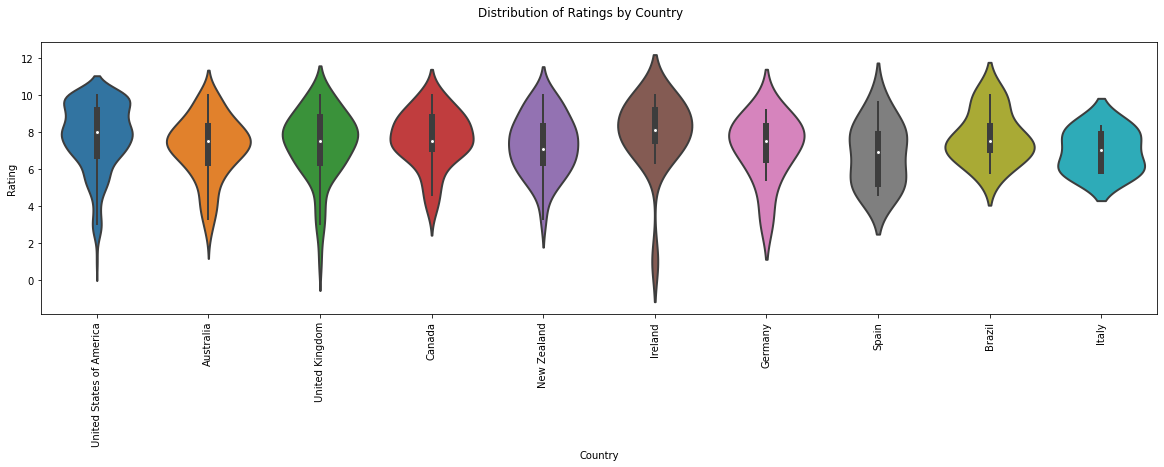

In [25]:
top10_list = top10_df['Country'].tolist()
top10 = reviewer_info[reviewer_info.Country.isin(top10_list)]

fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax = sns.violinplot(x = 'Country', 
                    y = 'Rating', 
                    data = top10, 
                    order = top10_list,
                    linewidth = 2) 
plt.suptitle('Distribution of Ratings by Country') 
plt.xticks(rotation=90);

In [26]:
#Define tag list
tag_list = ['Business','Leisure','Group','Couple','Family','friends','Solo']

#Count for each review tag
tag_counts = []
for tag in tag_list:
    counts = reviewer_info['Review_tags'].str.count(tag).sum()
    tag_counts.append(counts)

#Convert to a dataframe
trip_type = pd.DataFrame({'Trip Type':tag_list,'Counts':tag_counts}).sort_values('Counts',ascending = False)

#Visualize the trip type counts from Review_tags
fig = px.bar(trip_type, x='Trip Type', y='Counts', title='Review Tags Counts for each Trip Type')
fig.show()

## Lemmatize Tokens

In [27]:
# wordnet and treebank have different tagging systems
# Create a function to define a mapping between wordnet tags and POS tags 
def get_wordnet_pos(pos_tag):

    if pos_tag.startswith('J'):
        return wordnet.ADJ 

    elif pos_tag.startswith('V'):
        return wordnet.VERB 

    elif pos_tag.startswith('N'):
        return wordnet.NOUN

    elif pos_tag.startswith('R'):
        return wordnet.ADV
    
    else:
        return wordnet.NOUN # default, return wordnet tag "NOUN"

#Create a function to lemmatize tokens in the reviews
def lemmatized_tokens(text):
        text = text.lower()
        pattern = r'\b[a-zA-Z]{3,}\b'                 
        tokens = nltk.regexp_tokenize(text, pattern) # tokenize the text
        tagged_tokens = nltk.pos_tag(tokens)  # a list of tuples (word, pos_tag)
          
        stop_words = stopwords.words('english')
        new_stopwords = ["hotel","everything","anything","nothing","thing","need",
                        "good","great","excellent","perfect","much","even","really"]  #customize extra stop_words
        stop_words.extend(new_stopwords)
        stop_words = set(stop_words)
        
        wordnet_lemmatizer = WordNetLemmatizer()
        # get lemmatized tokens                             #call function "get_wordnet_pos"
        lemmatized_words=[wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) 
                  # tagged_tokens is a list of tuples (word, tag)
                  for (word, tag) in tagged_tokens \
                  # remove stop words
                  if word not in stop_words and \
                  # remove punctuations
                  word not in string.punctuation]

        return lemmatized_words


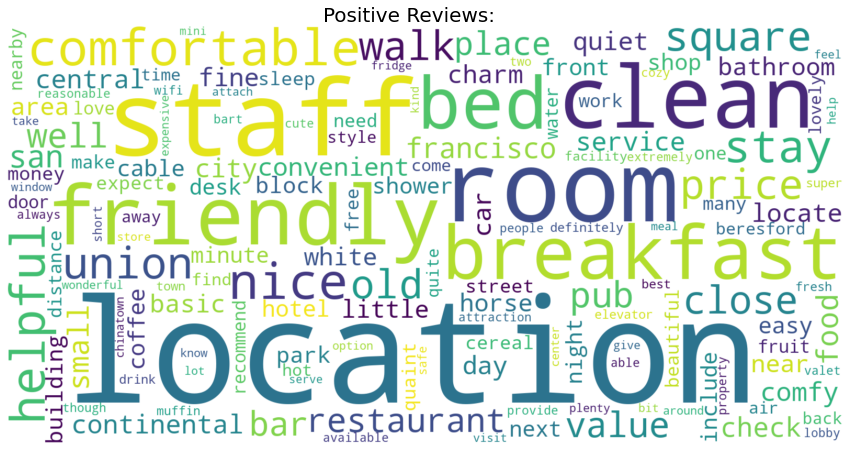

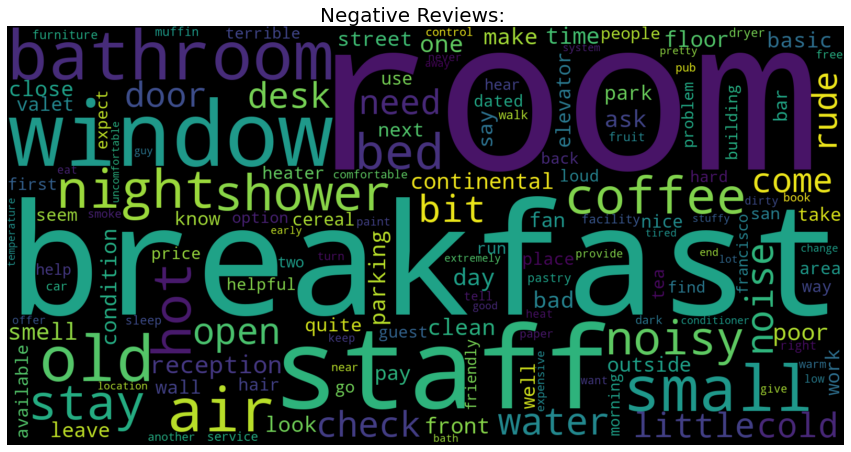

In [35]:
#Create a function to generate wordcloud
def wordcloud(review_df, review_colname, color, title):
    '''    
    INPUTS:
        reivew_df - dataframe, positive or negative reviews
        review_colname - column name, positive or negative review
        color - background color of worldcloud
        title - title of the wordcloud
    OUTPUT:
    Wordcloud visuazliation
    '''  
    text = review_df[review_colname].tolist()
    text_str = ' '.join(lemmatized_tokens(' '.join(text))) #call function "lemmatized_tokens"
    wordcloud = WordCloud(collocations = False,
                          background_color = color,
                          width=1600, 
                          height=800, 
                          margin=2,
                          min_font_size=20).generate(text_str)

    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figtext(.5,.8,title,fontsize = 20, ha='center')
    plt.show()     
    
# Wordcoulds for Positive Reviews
wordcloud(pos_reviews,'positive_reviews', 'white','Positive Reviews: ')

# # WordCoulds for Negative Reviews
wordcloud(neg_reviews,'negative_reviews', 'black', 'Negative Reviews:')


In [34]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sourav.n.saha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

## Sentiment Analysis

Here, we are using the Overall_review column in the reviewer_info dataframe to perform the sentiment analysis.

In [36]:
#Create a function to get the subjectivity
def subjectivity(text): 
    return TextBlob(text).sentiment.subjectivity

#Create a function to get the polarity
def polarity(text): 
    return TextBlob(text).sentiment.polarity

#Create two new columns
reviewer_info['Subjectivity'] = reviewer_info['Overall_review'].apply(subjectivity)
reviewer_info['Polarity'] = reviewer_info['Overall_review'].apply(polarity)
#################################################################################
#Create a function to compute the negative, neutral and positive analysis
def getAnalysis(score):
    if score <0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

reviewer_info['Analysis'] = reviewer_info['Polarity'].apply(getAnalysis)
#################################################################################
# plot the polarity and subjectivity
fig = px.scatter(reviewer_info, 
                 x='Polarity', 
                 y='Subjectivity', 
                 color = 'Analysis',
                 size='Subjectivity')

#add a vertical line at x=0 for Netural Reviews
fig.update_layout(title='Sentiment Analysis',
                  shapes=[dict(type= 'line',
                               yref= 'paper', y0= 0, y1= 1, 
                               xref= 'x', x0= 0, x1= 0)])
fig.show()

## LDA Topic Modelling

In [40]:
neg_reviews.head

<bound method NDFrame.head of                                       negative_reviews
0    Relatively basic, however it is great value fo...
1    The hotel is very dated with yellow staining o...
2    Very old water pipes which made noises during ...
3    Breakfast was rubbish.... two types of flakes ...
4                   The toilet is too low to the floor
..                                                 ...
610  Noisy and small room, bathroom too dated, “con...
611  Very noisy room because of generator noise out...
612  The shower was broken and the handles on furni...
613  A variety of pillows depths would've been appr...
614  Perhaps they can add more variety to the break...

[615 rows x 1 columns]>

The shape of the tfidf is (615, 138), meaning that there are 615 negative_reviews and 138 tokens made through the filtering process.
Best Model's Params:  {'learning_decay': 0.9, 'n_components': 5}
Model Log Likelihood Score:  -1831.1688196703424
Model Perplexity:  305.8764163280844


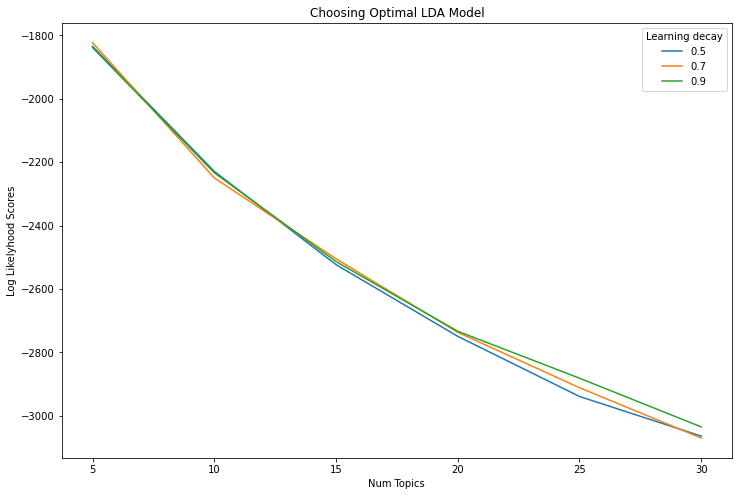

In [37]:
#Create a function to build the optimal LDA model
def optimal_lda_model(df_review, review_colname):
    '''
    INPUTS:
        df_review - dataframe that contains the reviews
        review_colname: name of column that contains reviews
        
    OUTPUTS:
        lda_tfidf - Latent Dirichlet Allocation (LDA) model
        dtm_tfidf - document-term matrix in the tfidf format
        tfidf_vectorizer - word frequency in the reviews
        A graph comparing LDA Model Performance Scores with different params
    '''
    docs_raw = df_review[review_colname].tolist()

    #************   Step 1: Convert to document-term matrix   ************#

    #Transform text to vector form using the vectorizer object 
    tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                    stop_words = 'english',
                                    lowercase = True,
                                    token_pattern = r'\b[a-zA-Z]{3,}\b', # num chars > 3 to avoid some meaningless words
                                    max_df = 0.9,                        # discard words that appear in > 90% of the reviews
                                    min_df = 10)                         # discard words that appear in < 10 reviews    

    #apply transformation
    tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())

    #convert to document-term matrix
    dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)  

    print("The shape of the tfidf is {}, meaning that there are {} {} and {} tokens made through the filtering process.".\
              format(dtm_tfidf.shape,dtm_tfidf.shape[0], review_colname, dtm_tfidf.shape[1]))

    
    #*******   Step 2: GridSearch & parameter tuning to find the optimal LDA model   *******#

    # Define Search Param
    search_params = {'n_components': [5, 10, 15, 20, 25, 30], 
                     'learning_decay': [.5, .7, .9]}

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params)

    # Do the Grid Search
    model.fit(dtm_tfidf)


    #*****  Step 3: Output the optimal lda model and its parameters  *****#

    # Best Model
    best_lda_model = model.best_estimator_

    # Model Parameters
    print("Best Model's Params: ", model.best_params_)

    # Log Likelihood Score: Higher the better
    print("Model Log Likelihood Score: ", model.best_score_)

    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    print("Model Perplexity: ", best_lda_model.perplexity(dtm_tfidf))


    #***********   Step 4: Compare LDA Model Performance Scores   ***********#

    #Get Log Likelyhoods from Grid Search Output
    gscore=model.fit(dtm_tfidf).cv_results_
    n_topics = [5, 10, 15, 20, 25, 30]

    log_likelyhoods_5 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.5]
    log_likelyhoods_7 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.7]
    log_likelyhoods_9 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.9]

    # Show graph
    plt.figure(figsize=(12, 8))
    plt.plot(n_topics, log_likelyhoods_5, label='0.5')
    plt.plot(n_topics, log_likelyhoods_7, label='0.7')
    plt.plot(n_topics, log_likelyhoods_9, label='0.9')
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics")
    plt.ylabel("Log Likelyhood Scores")
    plt.legend(title='Learning decay', loc='best')
    plt.show()
    
    return best_lda_model, dtm_tfidf, tfidf_vectorizer
    
best_lda_model, dtm_tfidf, tfidf_vectorizer = optimal_lda_model(neg_reviews, 'negative_reviews')


In [38]:
#Create a function to inspect the topics we created 
def display_topics(model, feature_names, n_top_words):
    '''
    INPUTS:
        model - the model we created
        feature_names - tells us what word each column in the matric represents
        n_top_words - number of top words to display
    OUTPUTS:
        a dataframe that contains the topics we created and the weights of each token
    '''
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx+1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx+1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)


display_topics(best_lda_model, tfidf_vectorizer.get_feature_names(), n_top_words = 20)

Topic 1 words Topic 1 weights Topic 2 words Topic 2 weights Topic 3 words  \
0      breakfast            46.5         staff            22.7          room   
1    continental            12.0          room            12.5           air   
2          basic            11.9          desk            12.1         small   
3         little            11.4          rude            12.0      bathroom   
4         coffee            10.6     reception            11.1           hot   
5          hotel            10.1          poor            10.1  conditioning   
6          dated             9.9         hotel             8.5         needs   
7           room             8.8          loud             8.3        window   
8      available             7.5        really             8.0        shower   
9         cereal             7.3          like             7.2         floor   
10         quite             7.2         check             7.1           old   
11         tired             7.0           bad             6.4         water   
12          hair             7.0           tea             6.4          need   
13          good             6.5        heater             6.1          door   
14         price             6.4        coffee             6.0       outside   
15        better             6.2          cold             5.7   conditioner   
16          work             6.2          didn             5.7           fan   
17         dryer             5.8       service             5.3        guests   
18          didn             5.5          stay             5.1           bit   
19         paper             5.2        looked             5.1     extremely   

   Topic 3 weights Topic 4 words Topic 4 weights  Topic 5 words  \
0             28.0       parking            13.9          noisy   
1             19.9         valet             8.5          rooms   
2             18.1          beds             8.1            old   
3             17.5       variety             7.3       elevator   
4             15.7     breakfast             7.1           room   
5             12.3       limited             6.6        helpful   
6             11.6     expensive             6.5            bit   
7             10.6         great             6.4          hotel   
8              9.9           got             6.2       friendly   
9              9.6        street             5.4          smell   
10             9.1   temperature             4.2            san   
11             8.9         night             4.2          close   
12             8.7           way             3.9          night   
13             7.6         early             3.7       building   
14             6.5          room             3.3      francisco   
15             5.7          near             3.3           free   
16             5.6          view             2.9          noise   
17             5.5          warm             2.9           hear   
18             5.0          nice             2.8          staff   
19             4.9          open             2.3  uncomfortable   

   Topic 5 weights  
0             15.6  
1             12.4  
2             10.8  
3              9.8  
4              8.9  
5              7.0  
6              6.4  
7              6.2  
8              6.2  
9              6.1  
10             6.1  
11             6.0  
12             5.8  
13             5.6  
14             5.5  
15             5.2  
16             5.2  
17             5.1  
18             4.9  
19             4.8

In [39]:
# Topic Modelling Visualization for the Negative Reviews
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tfidf, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.200505  0.125439       1        1  23.475727
0     -0.178526  0.108015       2        1  22.000356
1     -0.104477  0.025505       3        1  21.379913
4      0.090871 -0.054122       4        1  19.502139
3     -0.008373 -0.204836       5        1  13.641865, topic_info=          Term       Freq      Total Category  logprob  loglift
14   breakfast  55.000000  55.000000  Default  30.0000  30.0000
91     parking  16.000000  16.000000  Default  29.0000  29.0000
114      staff  26.000000  26.000000  Default  28.0000  28.0000
0          air  18.000000  18.000000  Default  27.0000  27.0000
84       noisy  15.000000  15.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
136    windows   1.464242   7.527622   Topic5  -4.7464   0.3548
14   breakfast   7.251447  55.215409   Topic5  -3.1465  -0.0380
83       noise   1.923290  11.910750   Topic5  -4.4737   0.1686
135     window   2.180630  14.853250   Topic5  -4.3481   0.0734
104       room   3.359669  54.519170   Topic5  -3.9159  -0.7947

[212 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.939160      air
2         1  0.242478      ask
2         3  0.484955      ask
2         5  0.242478      ask
3         3  0.389983    asked
...     ...       ...      ...
136       1  0.398532  windows
136       4  0.265688  windows
136       5  0.132844  windows
137       2  0.708972     work
137       4  0.141794     work

[290 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 5, 4])

source: https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08